# Set-up

## Import dependencies

In [1]:
import ast
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
import torch
from transformers import AutoTokenizer

## Top-level functions

In [2]:
def chart_type(spec):
    """Returns mark type for a given vega-lite specification"""
    if 'mark' in ast.literal_eval(spec).keys():
        return ast.literal_eval(spec)['mark']['type']
    else:
        return ast.literal_eval(spec)['hconcat'][0]['mark']


def summarise_data(df, column):
    """Outputs the value count for a given column in a dataframe."""
    summary = pd.DataFrame(dict(count=df[column].value_counts(),
                             perc=df[column].value_counts(normalize=True)
                               ))
    summary.loc['All'] = [df.shape[0], 1]
    return summary


def incontext_example(row):
    """Generates complete incontext example for a given a query"""
    return "Task: Using data from " + row['datasetURL'] + ", " + row['query'] + "\n" + \
        "Dataset schema: " + row['metaData'] + "\n" + "Specification: " + row['spec']


def prompt(row):
    """Generates incomplete prompt for a given query"""
    return "Task: Using data from " + row['datasetURL'] + ", " + row['query'] + "\n" + "Dataset schema: " + \
        row['metaData'] + "\n" + "Specification: {'$schema': 'https://vega.github.io/schema/vega-lite/v4.17.0.json',"


def training_set(train_df, indices):
    """Creates a sub-training set (DataFrame) with a sentence embedding and completed example for each query"""
    sub_train = train_df.iloc[indices, :].copy()
    sub_train.reset_index(inplace=True, drop=True)
    sub_train['complete_example']=sub_train.apply(incontext_example, axis=1)
    
    # # Add query embeddings
    # train_query_vectors = sentence_embedder.encode(sub_train["query"].tolist(),
    #                                    convert_to_tensor=True)
    # sub_train['query_embedding'] = train_query_vectors.tolist()
    return sub_train


def validation_set(train_df, indices):
    """Creates a validation set (DataFrame) with a sentence embedding and prompt for each query.
    Uncomment relevant code to filter by spec_type"""
    vset = train_df.iloc[indices, :].copy()
    vset['prompt'] = vset.apply(prompt, axis=1)
    # vset = vset.loc[vset["type"] == spec_type]
    vset.reset_index(inplace=True, drop=True)

    # # Add query embeddings
    # vset_query_vectors = sentence_embedder.encode(vset["query"].tolist(),
    #                                   convert_to_tensor=True)
    # vset['query_embedding'] = vset_query_vectors.tolist()
    return vset


def test_set(test_df):
    """Adds a sentence embedding and prompt for each query"""
    test_df['prompt'] = test_df.apply(prompt, axis=1)

    # # Add query embeddings
    # test_query_vectors = sentence_embedder.encode(test_df["query"].tolist(),
    #                                    convert_to_tensor=True)
    # test_df['query_embedding'] = test_query_vectors.tolist()
    return test_df


def similarity_match(row, sub_train):
    """Finds top 'nshot' matches between validation set queries and out-of-domain sub-training data"""
    if OOD:
        sub_train = sub_train.loc[row['dataset']!=sub_train['dataset']]
        
    similarity_scores = util.cos_sim(torch.tensor(row['query_embedding']),
                                     torch.tensor(sub_train['query_embedding'].tolist())
                                    )[0]
    top_matches = torch.topk(similarity_scores, largest=True, k=nshot)
    
    # Update top match indices so they reflect indices before filtering by domain
    updated_indices = torch.tensor([sub_train.index[i] for i in top_matches.indices.tolist()])
    for i in range(nshot):
        top_matches.indices[i] = updated_indices[i]
    return top_matches


def model_input(row, sub_train):
    """ Adds the top 'nshot' queries and corresponding similarity scores to the validation set DataFrame.
    The full context for each validation set query is then produced along with the final model input.
    The length of the final input in tokens is also determiend."""
    row['example_queries'] = [sub_train.loc[i, 'query'] for i in row['similarity_output'].indices.tolist()]
    row['example_scores'] = row['similarity_output'].values.tolist()
    
    complete_examples = [sub_train.loc[i, 'complete_example'] for i in row['similarity_output'].indices.tolist()]
    row['incontext_examples'] = 'Generate a vega-lite specification for the task\n' + '\n'.join(complete_examples[::-1])
    row['model_input'] = row['incontext_examples'] + '\n' + row['prompt']
    row['model_input_length'] = local_tokenizer(row['model_input'], return_tensors="pt", padding=False).input_ids.shape[1]
    row['spec_length'] = local_tokenizer(row['spec'], return_tensors="pt", padding=False).input_ids.shape[1]
    return row

## Parameters

In [3]:
raw_data_dir = 'C:/Users/billy/OneDrive/Documents/Python Scripts/1. Portfolio/1. NL2VIS/'
spec_type = 'Fully specified'
kfold_splits = 10
nshot = 3  # Max number of in-context examples in the train set
test_nshot = 3  # Max number of in-context examples in the test set
max_position_embeddings = 2048/1.1 # Max input size
OOD = False # Enter True for OOD matches

if spec_type == 'Under specified':
    spec_type_acronym = 'US'
elif spec_type == 'Fully specified':
    spec_type_acronym = 'FS'

## Import data

In [4]:
NLV_corpus = pd.read_csv(raw_data_dir + 'NLVcorpus.csv')
NL4DV_corpus = pd.read_csv(raw_data_dir + "NL4DVcorpus.csv")

corpus = pd.concat([
    NLV_corpus,
    NL4DV_corpus,
])
corpus.drop_duplicates(subset='query', keep='first', inplace=True)

# Instantiate models

## Tokenizer

In [5]:
tokenizer_directory = 'EleutherAI/gpt-neo-125M'
local_tokenizer = AutoTokenizer.from_pretrained(tokenizer_directory)

local_tokenizer.padding_side = "left"
local_tokenizer.pad_token = local_tokenizer.eos_token

## Sentence embedder

In [6]:
sentence_embedder = SentenceTransformer("paraphrase-MiniLM-L6-v2")  # https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2
# sentence_embedder = SentenceTransformer('all-mpnet-base-v2')

# Pre-processing steps

## Corpus amendments

In [7]:
# Remove unnecessary suffixes from domains
corpus['dataset'] = corpus['dataset'].apply(lambda x: x.removesuffix('.csv'))
corpus["dataset"] = corpus['dataset'].apply(lambda x: x.removesuffix('-w-year'))

# Add chart type
corpus['markType'] = corpus['spec'].map(lambda x: chart_type(x))

# Add query embedding
sentence_embeddings = sentence_embedder.encode(list(corpus.iloc[:, corpus.columns=='query'].values.flatten()),
                                               convert_to_tensor=True)
corpus['query_embedding'] = sentence_embeddings.tolist()
corpus.head()

,query,type,dataset,datasetURL,metaData,spec,markType,query_embedding
0,Scatterplot mpg vs displacement color by origin,Fully specified,cars,https://raw.githubusercontent.com/nlvcorpus/nl...,"{fields: [{field: Model, type: nominal}, {fiel...",{'$schema': 'https://vega.github.io/schema/veg...,point,"[-0.28238457441329956, -0.3850893974304199, -0..."
1,Relationship between IMDB Rating and Rotten To...,Under specified,movies,https://raw.githubusercontent.com/nlvcorpus/nl...,"{fields: [{field: Title, type: nominal}, {fiel...",{'$schema': 'https://vega.github.io/schema/veg...,point,"[0.2175920456647873, -0.11958479136228561, -0...."
2,Cylinders count bar chart Color by origin,Fully specified,cars,https://raw.githubusercontent.com/nlvcorpus/nl...,"{fields: [{field: Model, type: nominal}, {fiel...",{'$schema': 'https://vega.github.io/schema/veg...,bar,"[0.3103927969932556, 0.424814909696579, -0.187..."
3,histogram of running time,Fully specified,movies,https://raw.githubusercontent.com/nlvcorpus/nl...,"{fields: [{field: Title, type: nominal}, {fiel...",{'$schema': 'https://vega.github.io/schema/veg...,bar,"[-0.007709309458732605, -0.07974489778280258, ..."
4,Cylinders average mpg,Under specified,cars,https://raw.githubusercontent.com/nlvcorpus/nl...,"{fields: [{field: Model, type: nominal}, {fiel...",{'$schema': 'https://vega.github.io/schema/veg...,bar,"[0.27286240458488464, -0.09565886110067368, 0...."


## Training/test split

In [8]:
train, test = train_test_split(
    corpus,
    test_size=0.2,
    random_state=0,
    shuffle=True
)
train.reset_index(
    drop=True,
    inplace=True
)

test.reset_index(
    drop=True,
    inplace=True
)

In [9]:
# Training set - query type breakdown
train_qtype_summary = summarise_data(train, 'type')
print(train_qtype_summary)

# Training set - data source breakdown
train_dsource_summary = summarise_data(train, 'dataset')
print(train_dsource_summary)

# Training set - mark type breakdown
train_mtype_summary = summarise_data(train, 'markType')
print(train_mtype_summary)

                 count  perc
type                        
Under specified    416  0.65
Fully specified    224  0.35
All                640  1.00
            count      perc
dataset                    
cars          255  0.398438
movies        209  0.326562
superstore    166  0.259375
euro           10  0.015625
All           640  1.000000
          count      perc
markType                 
bar         322  0.503125
point       183  0.285938
line        126  0.196875
tick          4  0.006250
arc           2  0.003125
area          1  0.001563
text          1  0.001563
boxplot       1  0.001563
All         640  1.000000


In [10]:
# Test set - query type breakdown
test_qtype_summary = summarise_data(test, 'type')
print(test_qtype_summary)

# Test set - data source breakdown
test_dsource_summary = summarise_data(test, 'dataset')
print(test_dsource_summary)

# Test set - mark type breakdown
test_mtype_summary = summarise_data(test, 'markType')
print(test_mtype_summary)

                 count      perc
type                            
Under specified    103  0.639752
Fully specified     58  0.360248
All                161  1.000000
            count      perc
dataset                    
movies         57  0.354037
cars           57  0.354037
superstore     45  0.279503
euro            2  0.012422
All           161  1.000000
          count      perc
markType                 
bar          83  0.515528
point        50  0.310559
line         25  0.155280
text          1  0.006211
area          1  0.006211
tick          1  0.006211
All         161  1.000000


# Prompt engineering

## Validation sets

In [11]:
# Slit training data into K training/validation sets
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
kf = KFold(
    n_splits=kfold_splits,
    random_state=0,
    shuffle=True
)

In [12]:
# Configure validation sets
cv_vsets = []
for sub_train_indices, vset_indices in kf.split(train):

    # Create validation set
    vset = validation_set(train, vset_indices)

    # Create training data for producing in-context examples
    sub_train = training_set(train, sub_train_indices)

    # Match validation set queries with training data examples
    vset['similarity_output'] = vset.apply(lambda row: similarity_match(row, sub_train), axis=1)

    # Create final model inputs
    vset = vset.apply(lambda row: model_input(row, sub_train), axis=1)

    # Filter inputs larger than max_position_embeddings
    vset = vset.loc[vset['model_input_length'] + vset['spec_length'] <= max_position_embeddings]
    vset.reset_index(drop=True, inplace=True)
    cv_vsets.append(vset)

Token indices sequence length is longer than the specified maximum sequence length for this model (2112 > 2048). Running this sequence through the model will result in indexing errors


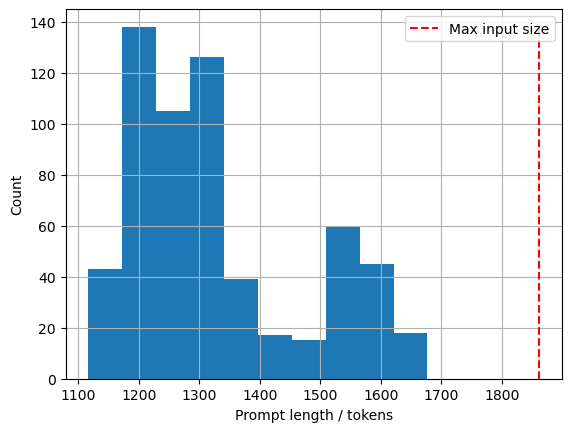

In [13]:
# Total prompt size
fig, axes = plt.subplots(nrows=1, ncols=1)
plt.style.use('seaborn-v0_8-muted')

count, length, _ = plt.hist(pd.concat([v['model_input_length'] for v in cv_vsets], axis=0))
plt.vlines(max_position_embeddings,
          ymin=0,
          ymax=max(count),
           linestyles='dashed',
          colors='r',
          label='Max input size')

axes.set_xlabel('Prompt length / tokens')
axes.set_ylabel('Count')
axes.grid(True)
axes.legend();

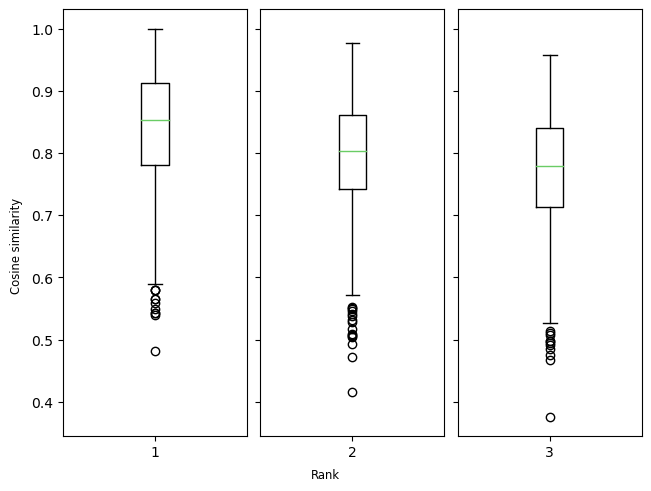

In [14]:
# Similarity score by position
def my_plotter(ax, i, data, param_dict={}):
    out = ax.boxplot(data, **param_dict)
    ax.set_xticks([1], labels=[i+1])
    return out

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, constrained_layout=True)
plt.style.use('seaborn-v0_8-muted')
for i, ax in enumerate(axes):
    data = pd.concat([v['example_scores'].map(lambda x: x[i]) for v in cv_vsets], axis=0)            
    my_plotter(ax, i, data)

fig.supxlabel('Rank', size='small');
fig.supylabel('Cosine similarity', size='small');

In [15]:
# Similarity score stats by position
data = pd.concat([v['example_scores'] for v in cv_vsets])
vset_similarity_summary = pd.concat([data.map(
    lambda x: x[i]).describe().rename(f"Rank {i}") for i in range(nshot)], axis=1)
vset_similarity_summary

,Rank 0,Rank 1,Rank 2
count,606.000000,606.000000,606.000000
mean,0.840187,0.795044,0.768908
std,0.098013,0.099163,0.099395
min,0.481630,0.415807,0.376272
25%,0.781284,0.741489,0.712755
50%,0.853904,0.802987,0.778586
75%,0.912902,0.861720,0.840254
max,1.000000,0.976896,0.958351


## Test set

In [16]:
# Match test set queries with training data examples
test = test_set(test)
train = training_set(train,
                 train.index==train.index)

test['similarity_output'] = test.apply(lambda row: similarity_match(row, train), axis=1)
test = test.apply(lambda row: model_input(row, train), axis=1)
test = test.loc[test['model_input_length'] + test['spec_length'] <= max_position_embeddings]
test.reset_index(drop=True, inplace=True)

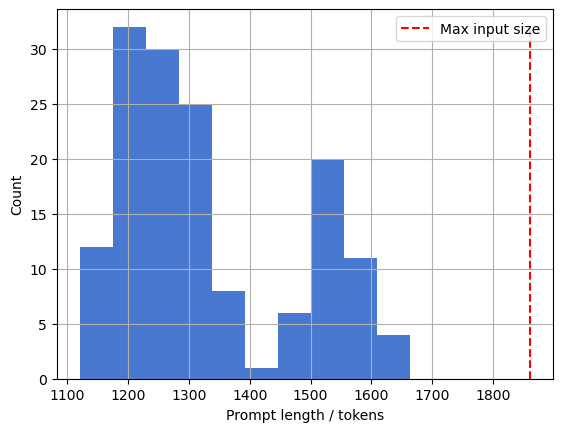

In [17]:
# Total prompt size
fig, axes = plt.subplots(nrows=1, ncols=1)
plt.style.use('seaborn-v0_8-muted')

count, length, _ = plt.hist(test['model_input_length'])
plt.vlines(max_position_embeddings,
          ymin=0,
          ymax=max(count),
           linestyles='dashed',
          colors='r',
          label='Max input size')

axes.set_xlabel('Prompt length / tokens')
axes.set_ylabel('Count')
axes.grid(True)
axes.legend();

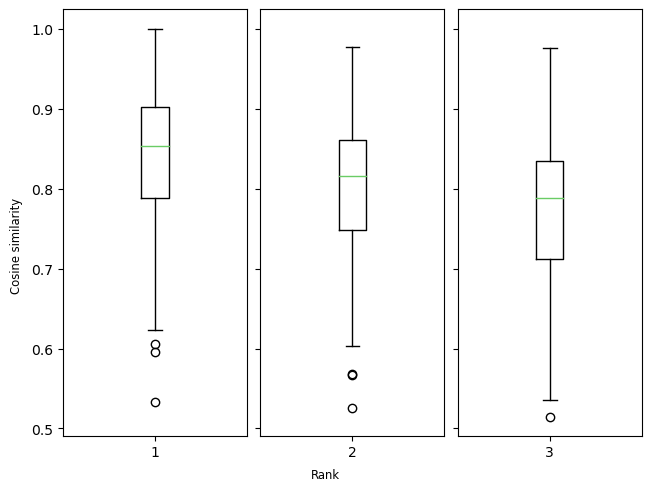

In [18]:
# Similarity score by position
def my_plotter(ax, i, data, param_dict={}):
    out = ax.boxplot(data, **param_dict)
    ax.set_xticks([1], labels=[i+1])
    return out

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, constrained_layout=True)
plt.style.use('seaborn-v0_8-muted')
for i, ax in enumerate(axes):       
    my_plotter(ax,i,
               test['example_scores'].map(lambda x: x[i])
              )

fig.supxlabel('Rank', size='small');
fig.supylabel('Cosine similarity', size='small');

In [19]:
# Similarity score stats by position
test_similarity_summary = pd.concat([test['example_scores'].map(
    lambda x: x[i]).describe().rename(f"Rank {i}") for i in range(nshot)], axis=1)
test_similarity_summary

,Rank 0,Rank 1,Rank 2
count,149.000000,149.000000,149.000000
mean,0.844332,0.803306,0.770875
std,0.091836,0.092086,0.095752
min,0.533325,0.525665,0.514907
25%,0.788666,0.747828,0.711785
50%,0.853263,0.815347,0.787784
75%,0.901761,0.861050,0.834777
max,1.000000,0.976673,0.975562


# Save files

In [20]:
# Save validation and test set objects via seriealisation into a binary format using pickle wb = write binary
if OOD:
    cv_file = '_'.join(['OOD', f'{str(nshot)}shot', f'{str(kfold_splits)}fold_vsets.pickle'])
    test_file = '_'.join(['OOD', f'{str(nshot)}shot', 'test_set.pickle'])
else:
    cv_file = '_'.join(['ID', f'{str(nshot)}shot', f'{str(kfold_splits)}fold_vsets.pickle'])
    test_file = '_'.join(['ID', f'{str(nshot)}shot', 'test_set.pickle'])

with open(cv_file, 'wb') as f:
    pickle.dump(cv_vsets, f)
with open(test_file, 'wb') as f:
    pickle.dump(test, f)